In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy.stats as stats
import tacco as tc
import openpyxl
import os
import warnings
warnings.filterwarnings("ignore")

# Sample KPMP038_S-2211-003960_Xen12

In [2]:
# read in matrix file
adata = sc.read_10x_h5(
    filename="/Users/stephreinert/Desktop/xenium/KPMP038_S-2211-003960_Xen12/xenium_2.0.0.io/data/cell_feature_matrix.h5"
)

In [3]:
# read in cells.csv
df = pd.read_csv(
    "/Users/stephreinert/Desktop/xenium/KPMP038_S-2211-003960_Xen12/xenium_2.0.0.io/data/cells.csv"
)

In [4]:
# update obs metadata with info from df
df.set_index(adata.obs_names, inplace = True)
adata.obs = df.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 141012 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
# storing x and y spatial coordinates of cells in anndata object 
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [7]:
# calculate quality control metrics and calculate cumulative sum for the top 10, 20, 50, and 150 genes
# add them to adata.obs and adata.var
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

## Pre-Filtering Negative Probe Count and Negative Decoding Count

In [8]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.003749435241316776
Negative Decoding Count %: 0.002356787865970545


## Pre QC Metrics

In [9]:
total_cell_area_um2 = 11610130.0
time_interval = 26

In [11]:
# transcripts per 100 µm² (use cell area)
cells_per_square_micrometer = adata.obs['transcript_counts'].sum() / (total_cell_area_um2) * 100
print(f"Total number of transcripts per 100 um squared: {cells_per_square_micrometer:.2f}")

# total cells
print(f"Total number of cells: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total Transcripts: {total_high_quality_transcripts}")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
number_of_cells = adata.shape[0]
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Total number of genes per cell (avg): {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell: {median_transcripts}")

# Calculate the total number of transcripts
total_transcripts = adata.X.sum()
# Calculate the number of transcripts assigned to cells
assigned_transcripts = adata.obs['total_counts'].sum()
# Calculate the number of transcripts not assigned to cells
unassigned_transcripts = total_transcripts - assigned_transcripts

# percentage of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
print(f"Cells without transcripts: {cells_without_transcripts}")
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts: {percentage_without_transcripts:.2f}%")

Total number of transcripts per 100 um squared: 96.48
Total number of cells: 141012
Total Transcripts: 11201687
Median number of genes per cell: 28.00
Total number of genes per cell (avg): 27.70
Median transcripts per cell: 61.0
Cells without transcripts: 282
Percentage of cells without transcripts: 0.20%


## Filtering and Processing

In [11]:
# remove cells with fewer than 5 total gene counts
sc.pp.filter_cells(adata, min_counts=5)

# remove genes that are not expressed in any cell
sc.pp.filter_genes(adata, min_cells=1)

In [12]:
# normalize counts per cell, logarithmize, PCA, compute neighborhood graph
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

## Initial UMAP

In [13]:
# embed the neighborhood graph of data and cluster cells into subgroups
sc.tl.umap(adata)
sc.tl.leiden(adata)

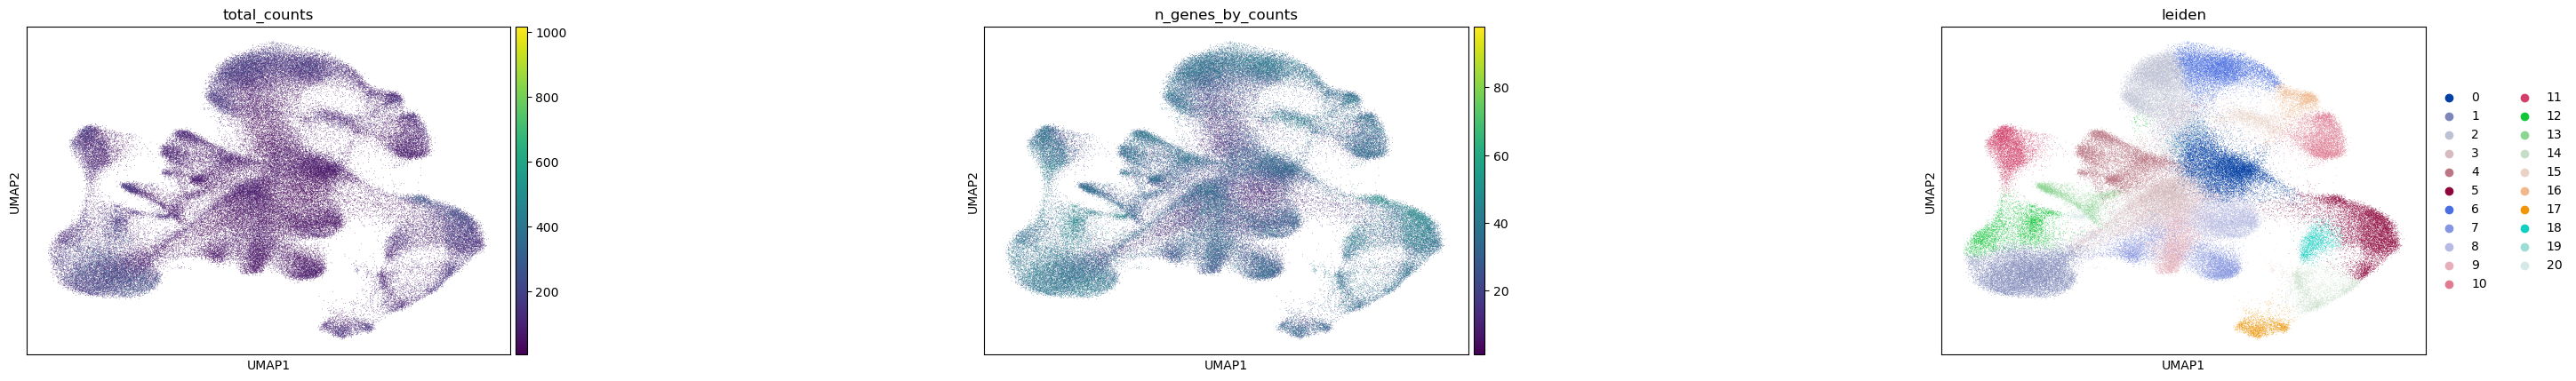

In [14]:
# umap
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.8,
)

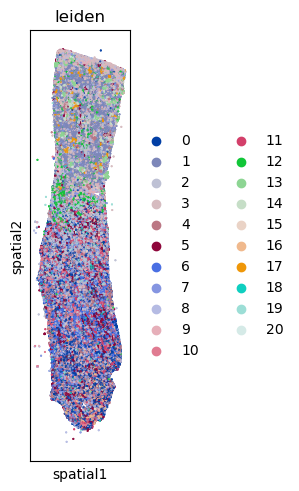

In [15]:
# spatial
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## False Discovery Rate

In [16]:
# total transcript calls (TTC)
total_transcript_calls = adata.obs['total_counts'].sum()
print(f"Total Transcript Calls: {total_transcript_calls}")

# negative control calls (NCC)
negative_control_calls = adata.obs['control_probe_counts'].sum()
print(f"Total Negative Control Calls: {negative_control_calls}")

# number of negative control probes (NCPs)
number_of_negative_control_probes = 20 ## VERIFY!

# number of real gene probes (RGPs)
number_of_panel_genes = 300 ## VERIFY!

# calculate FDR (10x)
fdr_step1 = (negative_control_calls / total_transcript_calls) * (number_of_panel_genes / number_of_negative_control_probes)
FDR_1 = fdr_step1 * 100
print(f"False Discovery Rate Xenium (FDR%): {FDR_1}%")

# calculate FDR (squidpy)
FDR_2 = (negative_control_calls / total_transcript_calls) * 100
print(f"False Discovery Rate Squidpy (FDR%): {FDR_2}%")

Total Transcript Calls: 11195505.0
Total Negative Control Calls: 420
False Discovery Rate Xenium (FDR%): 0.05627258439882792%
False Discovery Rate Squidpy (FDR%): 0.0037515056265885285%


## Post-Filtering Negative Probe Count and Negative Decoding Count

In [17]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.0037515056265885285
Negative Decoding Count %: 0.0023580892509985035


## Post-QC Metrics

In [18]:
# total cells per mm2
total_cell_area_mm = total_cell_area_um2 / 1000000
cells_per_square_millimeter = len(adata.obs) / (total_cell_area_mm)
print(f"Total number of cells per square millimeter: {cells_per_square_millimeter:.2f}")

# total transcripts per cell
number_of_cells = adata.shape[0]
total_high_quality_transcripts = adata.obs['transcript_counts'].sum() / number_of_cells
print(f"Total Transcripts per cell post-QC: {total_high_quality_transcripts}")

# total cells
print(f"Total number of cells post-QC: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total number of transcripts post-QC: {total_high_quality_transcripts}")

# average area per cell
average_cell_area = adata.obs['cell_area'].mean()
print(f"Average cell area post-QC: {average_cell_area:.2f}")

# percent of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts post-QC: {percentage_without_transcripts:.2f}%")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell post-QC: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Average number of genes per cell post-QC: {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell post-QC: {median_transcripts}")

Total number of cells per square millimeter: 11927.52
Total Transcripts per cell post-QC: 80.84564558058925
Total number of cells post-QC: 138480
Total number of transcripts post-QC: 11195505
Average cell area post-QC: 83.24
Percentage of cells without transcripts post-QC: 0.00%
Median number of genes per cell post-QC: 28.00
Average number of genes per cell post-QC: 28.17
Median transcripts per cell post-QC: 62.0


## Spatially Variable Genes

In [19]:
# calculate moran's I score
# I is the score, pval_norm is pvalue, var is variance, and corr_method is corrected p values
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [20]:
# inspect result
adata.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
UMOD     0.728153        0.0  0.000002         0.0  0.009901  0.000005   
AQP2     0.719839        0.0  0.000002         0.0  0.009901  0.000005   
CALB1    0.686489        0.0  0.000002         0.0  0.009901  0.000004   
SLC12A3  0.684420        0.0  0.000002         0.0  0.009901  0.000005   
SLC12A1  0.669238        0.0  0.000002         0.0  0.009901  0.000004   
HSD11B2  0.620213        0.0  0.000002         0.0  0.009901  0.000003   
NPHS2    0.618501        0.0  0.000002         0.0  0.009901  0.000004   
GATM     0.607825        0.0  0.000002         0.0  0.009901  0.000004   
AQP3     0.594162        0.0  0.000002         0.0  0.009901  0.000005   
SCNN1G   0.565843        0.0  0.000002         0.0  0.009901  0.000004   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
UMOD                  0.0                0.0         0.009951  
AQP2                  0.0                0.0         0.009951  
CALB1                 0.0                0.0         0.009951  
SLC12A3               0.0                0.0         0.009951  
SLC12A1               0.0                0.0         0.009951  
HSD11B2               0.0                0.0         0.009951  
NPHS2                 0.0                0.0         0.009951  
GATM                  0.0                0.0         0.009951  
AQP3                  0.0                0.0         0.009951  
SCNN1G                0.0                0.0         0.009951

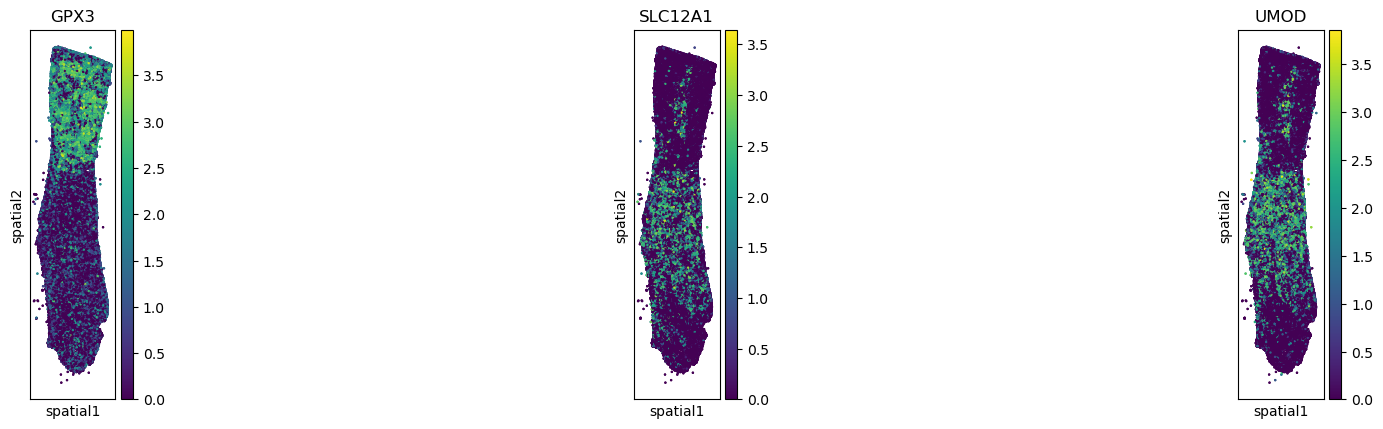

In [21]:
# plot selected highly variable genes
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "GPX3",
        "SLC12A1",
        "UMOD",
    ],
    shape=None,
    size=2,
    img=False,
)

## Gene Visualization

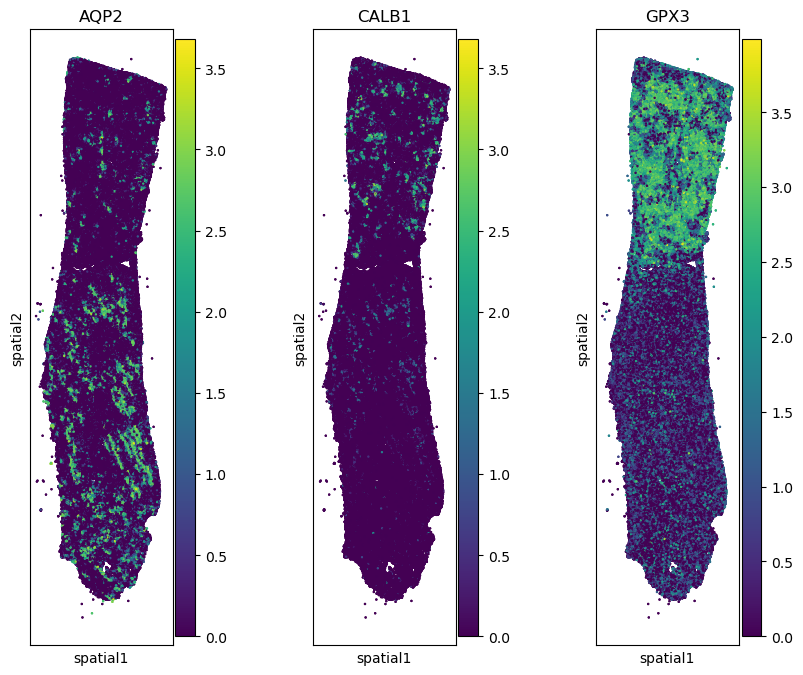

In [22]:
# visualize select genes
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "AQP2",
       "CALB1",
       "GPX3",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

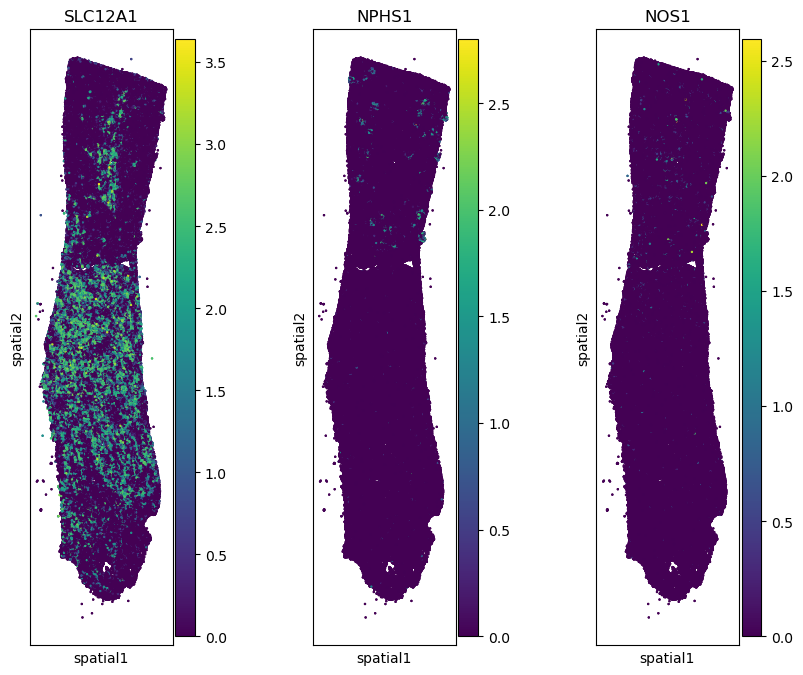

In [23]:
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "SLC12A1",
       "NPHS1",
       "NOS1",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

## Import Desired Reference Object

In [24]:
# adata_5000_nodegen = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_nodegen_5kcells.h5ad")
# adata_5000 = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_5kcells.h5ad")
adata_50prop = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/atlasv2_ds_50prop.h5ad")

## TACCO

In [25]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l1', result_key='v2.subclass.l1', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l1"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 90.25 seconds.
Starting annotation of data with shape (138480, 300) and a reference of shape (694294, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l1, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.3122799182309558 1.4688256871370888
bisection run on 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector E

AnnData object with n_obs × n_vars = 138480 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l1'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_

In [26]:
y = adata.obsm['v2.subclass.l1']
# Find the column where the value is 1.0
y['v2.subclass.l1'] = y.idxmax(axis=1)

In [27]:
adata.obs['v2.subclass.l1'] = y['v2.subclass.l1']

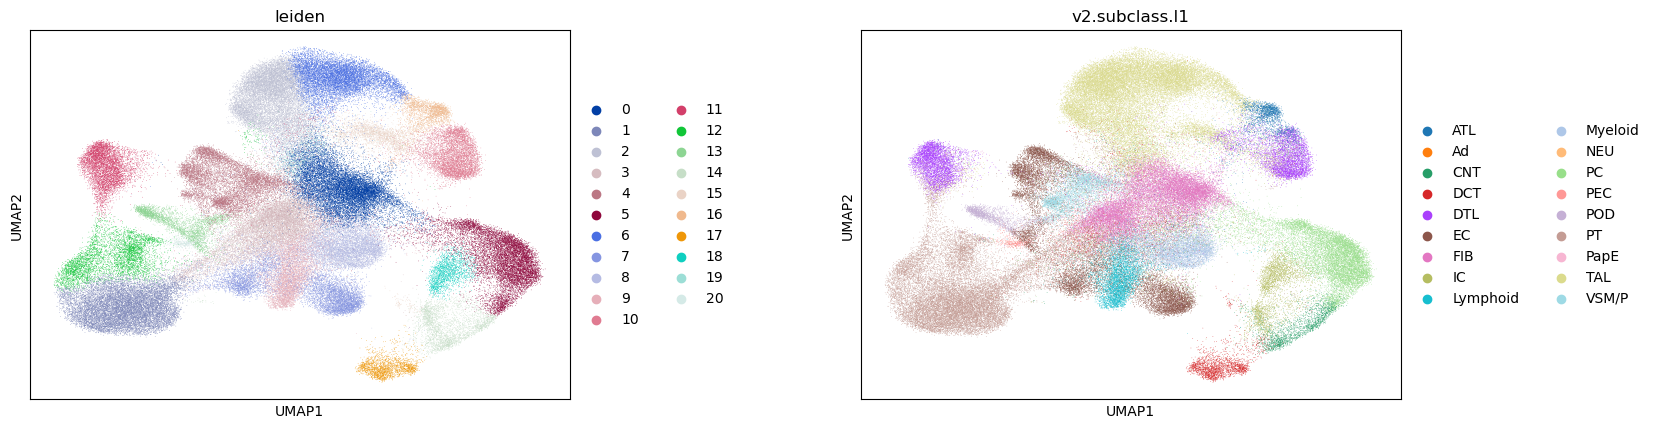

In [28]:
sc.pl.umap(
    adata,
    color=[
        "leiden",'v2.subclass.l1'
    ],
    wspace=0.4,
)

In [29]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
TAL         28920
PT          23368
FIB         17703
EC          13656
PC          11877
DTL          9553
Myeloid      6221
Lymphoid     5300
VSM/P        4766
IC           4035
DCT          3662
CNT          2530
POD          2484
ATL          2349
PEC          1485
PapE          473
NEU            69
Ad             29
Name: count, dtype: int64

In [30]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l2', result_key='v2.subclass.l2', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l2"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 99.36 seconds.
Starting annotation of data with shape (138480, 300) and a reference of shape (694294, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l2, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.3122799182309558 1.4688256871370888
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 20.5 s

AnnData object with n_obs × n_vars = 138480 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.l1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1', 'v2.subclass.l2'
    varm: 'PCs', 'v2.subclass.l1', 'v2.subcl

In [31]:
y = adata.obsm['v2.subclass.l2']
# find the column where the value is 1.0
y['v2.subclass.l2'] = y.idxmax(axis=1)

In [32]:
adata.obs['v2.subclass.l2'] = y['v2.subclass.l2']
adata.obs

cell_id   x_centroid   y_centroid  transcript_counts  \
aaaaieaj-1  aaaaieaj-1  2231.181885   575.185303                118   
aaaaijoo-1  aaaaijoo-1  2273.720703   641.444519                 47   
aaabioib-1  aaabioib-1  2261.821777   619.321594                 71   
aaabipjj-1  aaabipjj-1  2271.071777   568.572083                 56   
aaabkgmi-1  aaabkgmi-1  2284.304688   630.796570                 63   
...                ...          ...          ...                ...   
oileghea-1  oileghea-1  2357.869873  7621.990234                 89   
oilejhpc-1  oilejhpc-1  2381.356445  7853.123535                 11   
oilgkdip-1  oilgkdip-1  2348.447998  8145.003418                 83   
oilgmgla-1  oilgmgla-1  2387.468506  8196.808594                 19   
oilhccml-1  oilhccml-1  2444.264404  8104.105957                117   

            control_probe_counts  control_codeword_counts  \
aaaaieaj-1                     0                        0   
aaaaijoo-1                     0                        0   
aaabioib-1                     0                        0   
aaabipjj-1                     0                        0   
aaabkgmi-1                     0                        0   
...                          ...                      ...   
oileghea-1                     0                        0   
oilejhpc-1                     0                        0   
oilgkdip-1                     0                        0   
oilgmgla-1                     0                        0   
oilhccml-1                     0                        0   

            unassigned_codeword_counts  deprecated_codeword_counts  \
aaaaieaj-1                           0                           0   
aaaaijoo-1                           0                           0   
aaabioib-1                           0                           0   
aaabipjj-1                           0                           0   
aaabkgmi-1                           0                           0   
...                                ...                         ...   
oileghea-1                           0                           0   
oilejhpc-1                           0                           0   
oilgkdip-1                           0                           0   
oilgmgla-1                           0                           0   
oilhccml-1                           0                           0   

            total_counts   cell_area  ...  log1p_n_genes_by_counts  \
aaaaieaj-1         118.0  116.774067  ...                 3.871201   
aaaaijoo-1          47.0   55.542190  ...                 3.178054   
aaabioib-1          71.0   55.722815  ...                 3.637586   
aaabipjj-1          56.0   58.296721  ...                 3.465736   
aaabkgmi-1          63.0   66.424846  ...                 3.367296   
...                  ...         ...  ...                      ...   
oileghea-1          89.0  132.578755  ...                 3.828641   
oilejhpc-1          11.0   15.353126  ...                 2.397895   
oilgkdip-1          83.0  126.979380  ...                 3.367296   
oilgmgla-1          19.0   10.431094  ...                 2.197225   
oilhccml-1         117.0  199.319695  ...                 3.871201   

            log1p_total_counts  pct_counts_in_top_10_genes  \
aaaaieaj-1            4.779123                   54.237288   
aaaaijoo-1            3.871201                   65.957447   
aaabioib-1            4.276666                   50.704225   
aaabipjj-1            4.043051                   62.500000   
aaabkgmi-1            4.158883                   63.492063   
...                        ...                         ...   
oileghea-1            4.499810                   51.685393   
oilejhpc-1            2.484907                  100.000000   
oilgkdip-1            4.430817                   75.903614   
oilgmgla-1            2.995732                  100.000000   
oilhccml-1            4.770685                   54.700855   

  

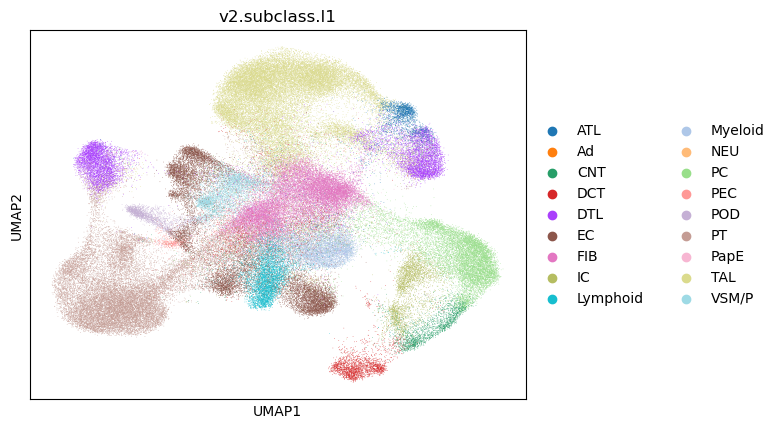

In [33]:
sc.pl.umap(adata, color=['v2.subclass.l1'], save="KPMP038_Xen12_umap_l1.png")

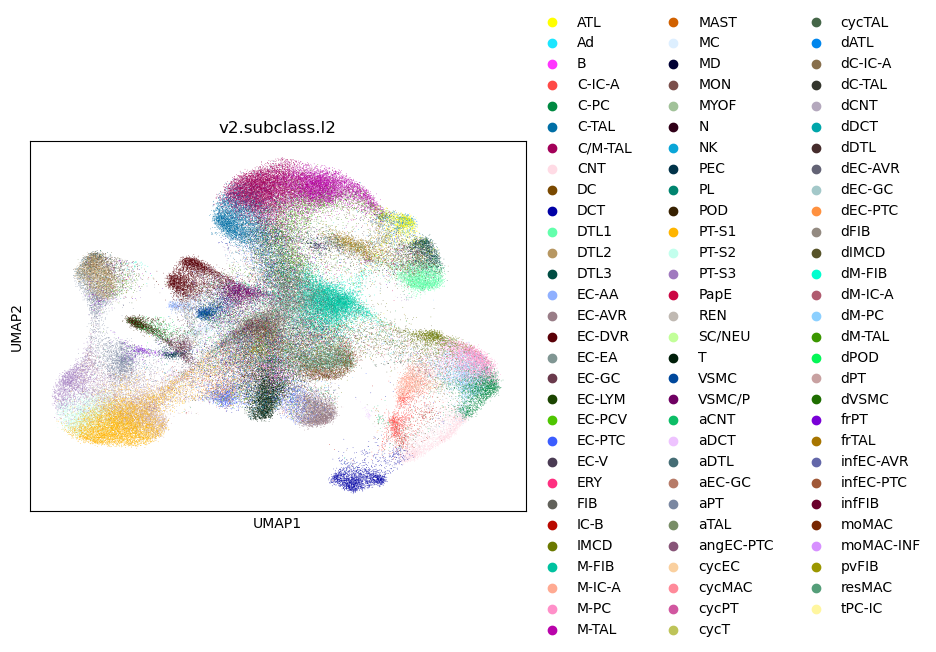

In [34]:
sc.pl.umap(adata, color=['v2.subclass.l2'], save="KPMP038_Xen12_umap_l2.png")

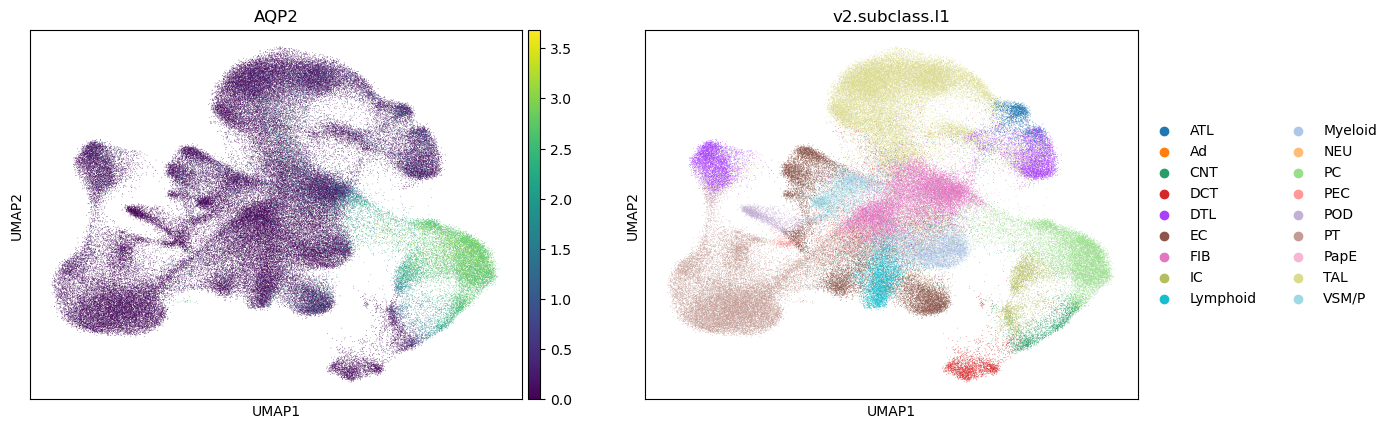

In [35]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l1'])

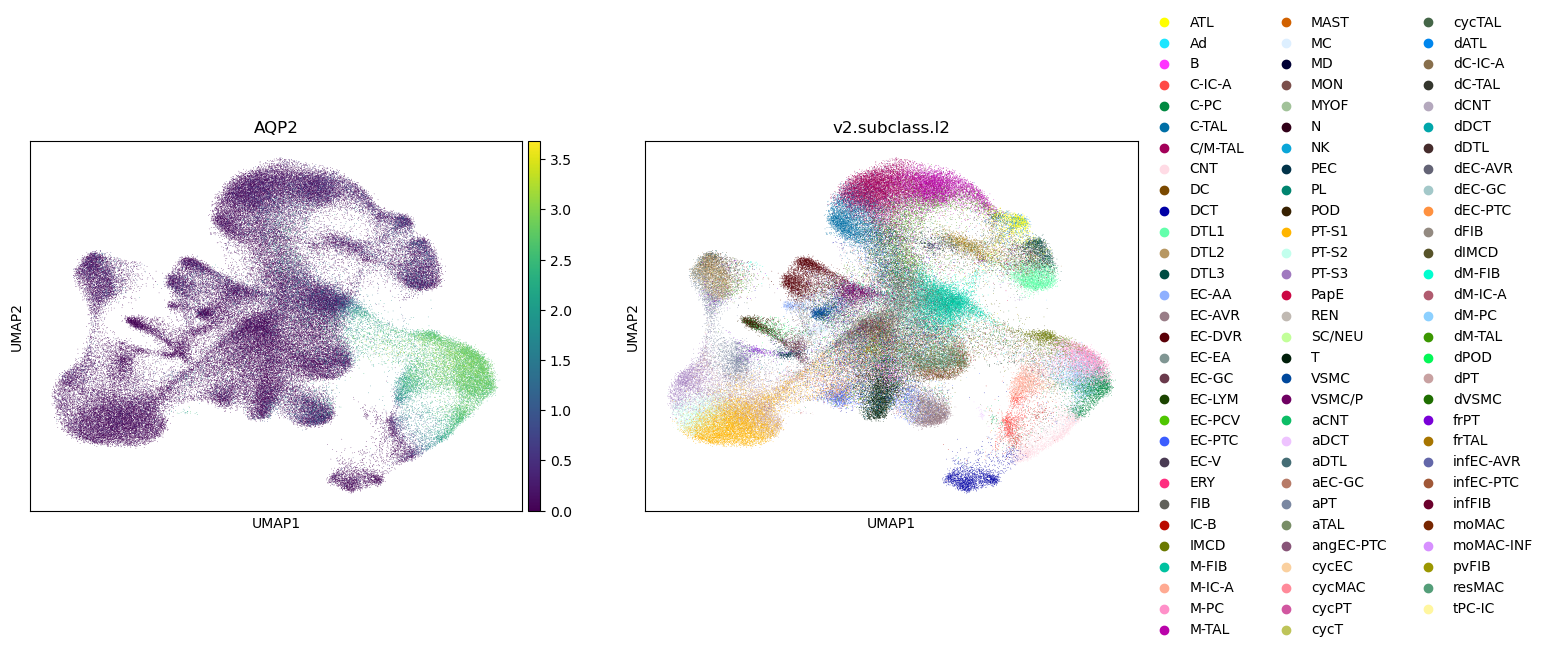

In [36]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l2'])

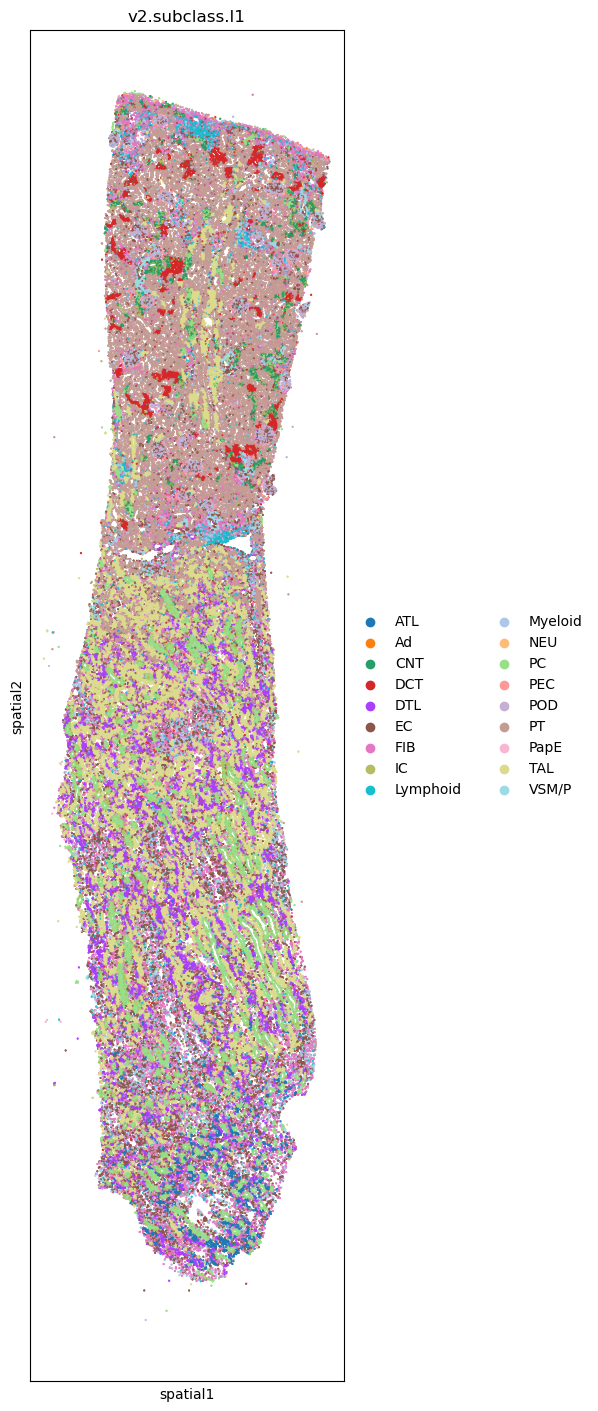

In [37]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    figsize = (16,14),
    color=[
        "v2.subclass.l1",
    ],
)

plt.savefig('/Users/stephreinert/Desktop/xenium/figures/KPMP038_Xen12_spatial_scatter_plot.png', dpi=300, bbox_inches='tight')

In [38]:
pd.crosstab(index=adata.obs['v2.subclass.l2'], columns=adata.obs['v2.subclass.l1'])

v2.subclass.l1   ATL  Ad  CNT  DCT  DTL  EC  FIB    IC  Lymphoid  Myeloid  \
v2.subclass.l2                                                              
ATL             1149   0    0    1   26   1    5     3         1        1   
Ad                 0   7    0    0    0   3    3     0         0        0   
B                  0   0    1    2    0   6   30     4       342       37   
C-IC-A             0   0    5   11    0   8    6  1398         0        1   
C-PC               0   0   37    2    0   0    9    31         0        0   
...              ...  ..  ...  ...  ...  ..  ...   ...       ...      ...   
moMAC              0   0    0    0    0   3    5     0         7      428   
moMAC-INF          0   0    0    0    0   0    2     0         8       97   
pvFIB              0   4    4    4    0   7  598     7         8       12   
resMAC             1   0    8   15    3  24  104    11        19     3264   
tPC-IC             0   0    0    0    0   0    0    50         0        0   

v2.subclass.l1  NEU    PC  PEC  POD  PT  PapE  TAL  VSM/P  
v2.subclass.l2                                             
ATL               0     2    0    0   0     2   85      0  
Ad                0     1    0    0   2     0    0      5  
B                 0     0    4    4   5     0    2      1  
C-IC-A            0     2    0    4   8     1    2      0  
C-PC              0  2453    0    1   1     2    1      0  
...             ...   ...  ...  ...  ..   ...  ...    ...  
moMAC             0     2    1    3   2     1    2      0  
moMAC-INF         0     0    0    1   1     0    0      0  
pvFIB             2     4   27    7  13     4    2     14  
resMAC            0     3    1    8  59     5   42      3  
tPC-IC            0    36    0    0   0     0    0      0  

[89 rows x 18 columns]

In [39]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
TAL         28920
PT          23368
FIB         17703
EC          13656
PC          11877
DTL          9553
Myeloid      6221
Lymphoid     5300
VSM/P        4766
IC           4035
DCT          3662
CNT          2530
POD          2484
ATL          2349
PEC          1485
PapE          473
NEU            69
Ad             29
Name: count, dtype: int64

In [40]:
# calculate the value counts
value_counts = adata.obs['v2.subclass.l2'].value_counts()

# convert the value counts to a DataFrame
value_counts_df = value_counts.reset_index()

# rename columns for better readability
value_counts_df.columns = ['v2.subclass.l2', 'count']

# set pandas option to display all rows
pd.set_option('display.max_rows', None)

# display
print(value_counts_df)

   v2.subclass.l2  count
0           PT-S1   8666
1         C/M-TAL   8613
2           M-TAL   6589
3           M-FIB   5884
4           C-TAL   5815
5             FIB   5782
6             dPT   4957
7               T   4181
8          dM-TAL   3735
9             aPT   3610
10         EC-DVR   3585
11         resMAC   3570
12         EC-AVR   3426
13           M-PC   3101
14            DCT   3018
15           DTL1   2909
16          PT-S3   2854
17           DTL2   2832
18            CNT   2549
19           C-PC   2537
20         VSMC/P   2505
21          dM-PC   2378
22          PT-S2   2261
23         EC-PTC   2224
24         dM-FIB   2079
25           IMCD   1900
26            POD   1525
27         C-IC-A   1446
28            PEC   1429
29          dIMCD   1427
30          frTAL   1422
31           aTAL   1379
32         M-IC-A   1342
33           VSMC   1319
34           dDTL   1309
35           DTL3   1287
36            ATL   1276
37           MYOF   1267
38             DC   1243


In [41]:
# number of cells per cell type in 'v2.subclass.l1'
cell_counts_per_type = adata.obs['v2.subclass.l1'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l1', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l1'
cell_proportion_per_type = adata.obs['v2.subclass.l1'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l1', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l1')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/KPMP038_Xen12_subclass_counts_l1.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l1  cell_count  proportion (%)
16            TAL       28920       20.883882
14             PT       23368       16.874639
6             FIB       17703       12.783795
5              EC       13656        9.861352
11             PC       11877        8.576690
4             DTL        9553        6.898469
9         Myeloid        6221        4.492345
8        Lymphoid        5300        3.827267
17          VSM/P        4766        3.441652
7              IC        4035        2.913778
3             DCT        3662        2.644425
2             CNT        2530        1.826979
13            POD        2484        1.793761
0             ATL        2349        1.696274
12            PEC        1485        1.072357
15           PapE         473        0.341566
10            NEU          69        0.049827
1              Ad          29        0.020942
DataFrame saved to /Users/stephreinert/Desktop/xenium/stats/KPMP038_Xen12_subclass_counts_l1.xlsx


In [42]:
# number of cells per cell type in 'v2.subclass.l2'
cell_counts_per_type = adata.obs['v2.subclass.l2'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l2', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l2'
cell_proportion_per_type = adata.obs['v2.subclass.l2'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l2', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l2')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/KPMP038_Xen12_subclass_counts_l2.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l2  cell_count  proportion (%)
40          PT-S1        8666        6.257943
6         C/M-TAL        8613        6.219671
29          M-TAL        6589        4.758088
26          M-FIB        5884        4.248989
5           C-TAL        5815        4.199162
23            FIB        5782        4.175332
77            dPT        4957        3.579578
46              T        4181        3.019209
75         dM-TAL        3735        2.697140
53            aPT        3610        2.606875
15         EC-DVR        3585        2.588821
87         resMAC        3570        2.577990
14         EC-AVR        3426        2.474003
28           M-PC        3101        2.239313
9             DCT        3018        2.179376
10           DTL1        2909        2.100664
42          PT-S3        2854        2.060947
11           DTL2        2832        2.045061
7             CNT        2549        1.840699
4            C-PC        2537        1.832034
48         VSMC/P        2505     

## Add Metadata

In [43]:
adata.obs['sample_id'] = 'S-2211-003960'
adata.obs['library_id'] = 'Xen_12'
adata.obs['Panel'] = '300KID'
adata.obs['PPID'] = 'KPMP_038'
adata.obs['Condition'] = 'Reference Tissue (Unknown Clinical Status)'
adata.obs['sample_source'] = 'Nephrectomy'
adata.obs['time_interval'] = '26'
adata.obs['region'] = 'Cortex_Medulla'
adata.obs['full_id'] = 'KPMP038_Xen12'

In [44]:
adata

AnnData object with n_obs × n_vars = 138480 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'v2.subclass.l2', 'sample_id', 'library_id', 'Panel', 'PPID', 'Condition', 'sample_source', 'time_interval', 'region', 'full_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.

## Neighborhood

In [45]:
sq.gr.nhood_enrichment(adata, cluster_key="v2.subclass.l1")

  0%|          | 0/1000 [00:00<?, ?/s]

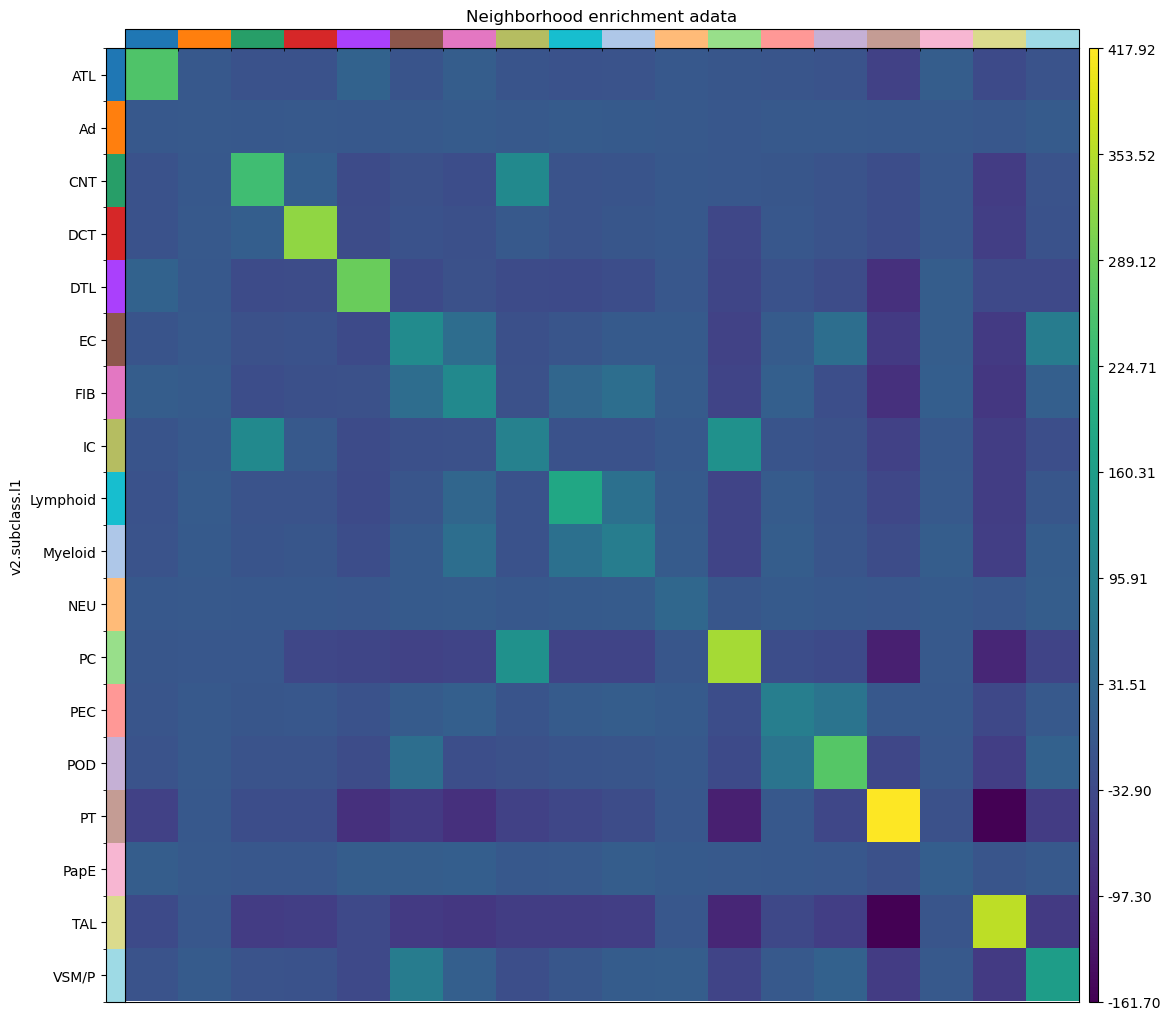

In [46]:
sq.pl.nhood_enrichment(
    adata,
    cluster_key="v2.subclass.l1",
    figsize=(10, 10),
    title="Neighborhood enrichment adata"
)
plt.savefig('/Users/stephreinert/Desktop/xenium/figures/KPMP038_Xen12_neighborhood_enrichment.png', dpi=300, bbox_inches='tight')

## Save Object

In [47]:
# remove a specific key from the obsm attribute, e.g., 'v2.subclass.l1'
del adata.obsm['v2.subclass.l1']

# remove another specific key from the obsm attribute, e.g., 'v2.subclass.l2'
del adata.obsm['v2.subclass.l2']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l1']

# remove another specific key from the varm attribute, e.g., 'v2.subclass.l2'
del adata.varm['v2.subclass.l2']

In [48]:
adata.write_h5ad("/Users/stephreinert/Desktop/xenium/objects/KPMP038_Xen12_obj.h5ad")